In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import cmasher as cmr

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

In [2]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

rtree1 = pklload(f"{database1}/reduced_tree.pickle")

print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [3]:
mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gals2 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hals2 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2 = None; allsubs2 = None; states2 = None
keys2 = list(LG2.keys())
for key in keys2:
    sats = LG2[key]['sats']; subs = LG2[key]['subs']; real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats2 = sats if allsats2 is None else np.hstack((allsats2, sats))
    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
dinks2 = allsubs2[states2 == 'dink']
pairs2 = allsubs2[states2 == 'pair']
upairs2 = allsubs2[states2 == 'upair']

rtree2 = pklload(f"{database2}/reduced_tree.pickle")

print(len(allsubs2), np.unique(states2, return_counts=True))

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


Let's find these cases:  
- A) No star forever
- B) Initially no, but SF via merger(or other events)
- C) Initially no, but ex-situ star came in
- D) Initial SF

# Case A  
No star forever

  0%|          | 0/1336 [00:00<?, ?it/s]

43
5613 8.130581979667463
5936 8.426168365277922
20744 8.684488602034499
24319 8.701314060412125
25089 8.977625422872748
[935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918
 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900
 899 898 897 896 895 894 893 892]
25089


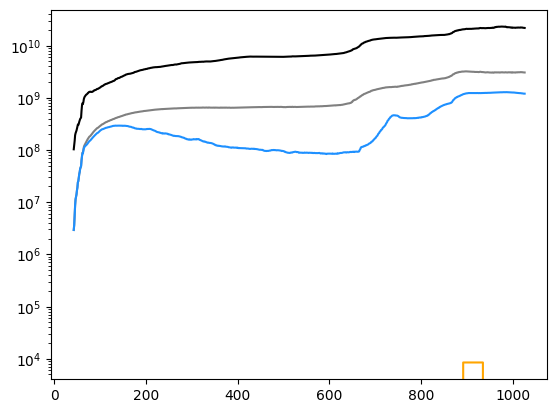

In [4]:
ids = []
for target in tqdm(allsubs1):
    branch = rtree1[target['id']]
    if(np.min(branch['timestep']) > 60): continue
    if(np.sum(branch['mstar_vir']>0) > 100): continue
    ids.append(target['id'])
print(len(ids))
tid=0; mean_mass=0
for iid in ids:
    branch = rtree1[iid]; tmp = branch[branch['timestep'] < 100]
    tmp = np.mean(tmp['mdm_vir'])
    if(tmp > mean_mass):
        tid = iid; mean_mass = tmp
        print(iid, np.log10(mean_mass))

target = allsubs1[allsubs1['id'] == tid][0]
branch = rtree1[tid]
fig, ax = plt.subplots(dpi=100)
ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
ax.plot(branch['timestep'], branch['mcell_vir'], color='grey')
ax.plot(branch['timestep'], branch['mcold_vir'], color='dodgerblue')
ax.set_yscale('log')
print(branch[branch['mstar_vir']>0]['timestep'])
print(target['id'])

**-> 25089 Running!**

# Case B  
Initially no, but SF via merger(or other events)

  0%|          | 0/1336 [00:00<?, ?it/s]

20
20821 8.59491719277879
24590 8.648169388807798
[73 72 71 70 69]
24590


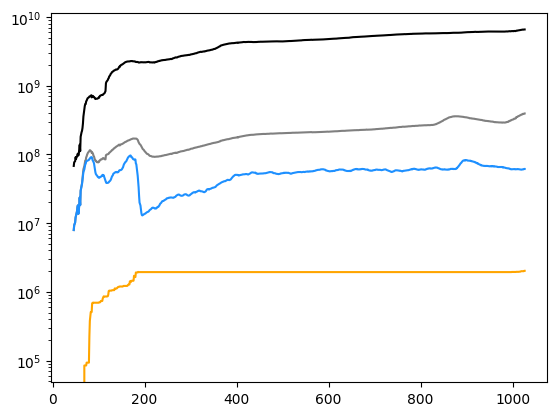

In [26]:
ids = []
for target in tqdm(allsubs1):
    branch = rtree1[target['id']]
    if(np.min(branch['timestep']) > 60): continue
    
    # Initial merging
    tmp = branch['mdm_vir']
    ddm = tmp[:-1]/tmp[1:]
    if(np.max(ddm[-50:]) < 1.5): continue

    # Initially no star
    if( np.sum(branch['mstar_vir'][-20:])>0 ): continue
    if( np.sum(branch['mstar_vir'][-120:-20])==0 ): continue
    # print(target['id'], np.max(ddm[-50:]))

    ids.append(target['id'])
print(len(ids))
banlist = [
           24508, 24264, 22467, 24831, 24299,26102, 24272, 24512, 24652, 24308, 21085, 20541, 20561, 24858, 
           26099, 20716, 24518, 26196, 24387, 26181, 24616, 25133, 24840, 22512
           ]
tid=0; mean_mass=0
for iid in ids:
    if(iid in banlist): continue
    branch = rtree1[iid]; tmp = branch[branch['timestep'] < 100]
    tmp = np.mean(tmp['mdm_vir'])
    if(tmp > mean_mass):
        tid = iid; mean_mass = tmp
        print(iid, np.log10(mean_mass))

# tid = 24518
target = allsubs1[allsubs1['id'] == tid][0]
branch = rtree1[tid]
print(branch[branch['mstar_vir']>0]['timestep'][-5:])
fig, ax = plt.subplots(dpi=100)
ax.plot(branch['timestep'], branch['mdm_vir'], color='k')
ax.plot(branch['timestep'], branch['mstar_vir'], color='orange')
ax.plot(branch['timestep'], branch['mcell_vir'], color='grey')
ax.plot(branch['timestep'], branch['mcold_vir'], color='dodgerblue')
ax.set_yscale('log')
print(target['id'])

**-> 26196 Running!**

# Case C)
Initially no, but ex-situ star came in


**-> 24590 Running!**

# Case D)
Initial SF